<a href="https://colab.research.google.com/github/antoniaz24/HousingPrices/blob/main/Final_Datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Regression Task

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.linear_model import ElasticNetCV
from sklearn.compose import make_column_transformer
import pickle
import xgboost as xgb
import multiprocessing
from sklearn.model_selection import GridSearchCV

In [ ]:
#Import the given data as a pd dataframe
data = pd.read_csv('train_data_housing_prices.csv')
#Taking a look at the data
print(data.head())

   Unnamed: 0  Property Name    Price        House Type  Area in sq ft  \
0           0    Queens Road  1675000             House           2716   
1           1  Seward Street   650000  Flat / Apartment            814   
2           2    Hotham Road   735000  Flat / Apartment            761   
3           3   Festing Road  1765000             House           1986   
4           4   Spencer Walk   675000  Flat / Apartment            700   

   No. of Bedrooms  No. of Bathrooms  No. of Receptions     Location  \
0                5                 5                  5    Wimbledon   
1                2                 2                  2  Clerkenwell   
2                2                 2                  2       Putney   
3                4                 4                  4       Putney   
4                2                 2                  2       Putney   

  City/County Postal Code  
0      London    SW19 8NY  
1      London    EC1V 3PA  
2      London    SW15 1QL  
3      Lon

In [ ]:
def pre_process(fname, post_dict, mean):
  """
  This function takes in the testing data and the post_dict (post codes dictionary built from the training data)
  and outputs pre-processed data in the form X and y to use for the model
  """
  data = pd.read_csv(fname)
  transformed = transformer.transform(data)
  transformed_data = pd.DataFrame(
      transformed, 
      columns=transformer.get_feature_names())
  transformed_data.columns = transformed_data.columns.str.replace('onehotencoder__', '')
  transformed_data.columns = transformed_data.columns.str.replace('remainder__', '')
  #print(transformed_data.head)
  data = transformed_data
  first_part = []
  postcodes = data['Postal Code']
  for i in range(len(data)):
    code = postcodes.iloc[i]
    first_half = code.split(' ')[0]
    first_part.append(first_half)
  data['post_first_half'] = first_part
  unique_ps = data['post_first_half'].unique()
  #price_per_area = data['Price']/data['Area in sq ft']
  #mean = np.mean(price_per_area)
  for ps in unique_ps:
    try:
      data.replace(ps, post_dict[ps], inplace=True)
    except:
      data.replace(ps, mean, inplace=True)
  
  df = data
  encoding = df.iloc[:, :8]
  non_encoding = df.iloc[:, 8:]

  X_non_encoding = non_encoding.drop(['Property Name','Price', 'Location', 'City/County', 'Postal Code', 'Unnamed: 0'], axis=1)
  headings = X_non_encoding.columns
  y = df.loc[:, df.columns == 'Price']
  X_non_encoding=min_max_scaler.transform(X_non_encoding)
  X = pd.concat((encoding, pd.DataFrame(X_non_encoding, columns=headings)), axis=1)
  return X, y
  

**Data Cleaning and Checking**

The empty strings or the null cells are checked, to see which parts of the data are missing 

In [ ]:
print((data['House Type']== '').sum())
print((data['Area in sq ft'].isnull()).sum())
print((data['No. of Bedrooms'].isnull()).sum())
print((data['No. of Bathrooms'].isnull()).sum())
print((data['No. of Receptions'].isnull()).sum())
#print((data['Price'].isnull()))

0
0
0
0
0


One hot encoding

Use one hot encoding for the categorical column 'House Type':


In [ ]:
transformer = make_column_transformer(
    (OneHotEncoder(), ['House Type']),
    remainder='passthrough'
    )
transformed = transformer.fit_transform(data)

transformed_data = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names_out()
    )
#for simplicity, remove the prefixes in the new columns names
transformed_data.columns = transformed_data.columns.str.replace('onehotencoder__', '')
transformed_data.columns = transformed_data.columns.str.replace('remainder__', '')
#take a look at the dataframe with one hot encoding
print(transformed_data.columns)
print(transformed_data.head)

Index(['House Type_Bungalow', 'House Type_Duplex',
       'House Type_Flat / Apartment', 'House Type_House', 'House Type_Mews',
       'House Type_New development', 'House Type_Penthouse',
       'House Type_Studio', 'Unnamed: 0', 'Property Name', 'Price',
       'Area in sq ft', 'No. of Bedrooms', 'No. of Bathrooms',
       'No. of Receptions', 'Location', 'City/County', 'Postal Code'],
      dtype='object')
<bound method NDFrame.head of      House Type_Bungalow House Type_Duplex House Type_Flat / Apartment  \
0                    0.0               0.0                         0.0   
1                    0.0               0.0                         1.0   
2                    0.0               0.0                         1.0   
3                    0.0               0.0                         0.0   
4                    0.0               0.0                         1.0   
...                  ...               ...                         ...   
3135                 0.0               

Mean encoding

To encorporate the categorical data given in the columns such as location, city and post code, mean encoding is performed, where the post_code column is replaced with the mean of the rent price per sq ft in the corresponding postal district (given by the first half of the post code).

In [ ]:
data = transformed_data
#print(len(data))
first_part = []
postcodes = data['Postal Code']
for i in range(len(data)):
  code = postcodes.iloc[i]
  first_half = code.split(' ')[0]
  first_part.append(first_half)
data['post_first_half'] = first_part
print(data.head)

<bound method NDFrame.head of      House Type_Bungalow House Type_Duplex House Type_Flat / Apartment  \
0                    0.0               0.0                         0.0   
1                    0.0               0.0                         1.0   
2                    0.0               0.0                         1.0   
3                    0.0               0.0                         0.0   
4                    0.0               0.0                         1.0   
...                  ...               ...                         ...   
3135                 0.0               0.0                         0.0   
3136                 0.0               0.0                         1.0   
3137                 0.0               0.0                         0.0   
3138                 0.0               0.0                         0.0   
3139                 0.0               0.0                         0.0   

     House Type_House House Type_Mews House Type_New development  \
0            

A dictionary is created to map the postal district with the average price per sq ft in that district

In [ ]:
unique_ps = data['post_first_half'].unique()

post_dict = {}

for ps in unique_ps[0:]:
  post_dict[ps] = 0
  filtered_data = data[data['post_first_half'] == ps]
  #print(filtered_data)
  mean_price = filtered_data['Price'].mean()
  mean_size = filtered_data['Area in sq ft'].mean()
  mean_price_per_sq_ft = mean_price/mean_size
  post_dict[ps] = mean_price_per_sq_ft

print(unique_ps)
print(post_dict)

for ps in unique_ps:
  data.replace(ps, post_dict[ps], inplace=True)
print(data.head)

['SW19' 'EC1V' 'SW15' 'W2' 'SW11' 'SW6' 'W8' 'N6' 'NW8' 'NW1' 'TW1' 'CR5'
 'NW3' 'W11' 'SW9' 'W1G' 'SW3' 'N1' 'NW6' 'KT10' 'KT6' 'SW5' 'SW12' 'SW2'
 'W4' 'SW10' 'SW13' 'SW4' 'KT12' 'SW1P' 'E9' 'SW1W' 'N8' 'E5' 'SW16' 'W12'
 'WD19' 'HA6' 'E3' 'NW5' 'W1B' 'W5' 'KT7' 'SE7' 'EC1N' 'E8' 'E14' 'IG8'
 'KT5' 'W6' 'W9' 'NW11' 'SW1E' 'SE17' 'W1H' 'WC2R' 'IG10' 'SW14' 'SW17'
 'SW8' 'EC1A' 'KT2' 'SW18' 'TW9' 'TW10' 'SW1Y' 'SW1X' 'W14' 'N5' 'SE18'
 'WD7' 'E1' 'KT22' 'SE1' 'SE8' 'W13' 'WC1X' 'E1W' 'SW20' 'WC2H' 'SW7' 'E2'
 'N7' 'HA5' 'W1K' 'NW2' 'KT8' 'SE3' 'CM16' 'N4' 'UB9' 'SW1V' 'SE10' 'W1T'
 'W3' 'IG9' 'IG7' 'W1S' 'W1W' 'KT9' 'SE16' 'W1J' 'W1U' 'KT3' 'EC1R' 'SE21'
 'NW7' 'EC1M' 'HA7' 'EC2M' 'W7' 'W10' 'WC1E' 'E16' 'TW8' 'N16' 'KT21'
 'EC3R' 'EC2A' 'EN9' 'SW1H' 'EC1Y' 'WD23' 'E4' 'N2' 'TW7' 'HA4' 'WC2N'
 'WC1H' 'HA1' 'UB10' 'EC4V' 'BR6' 'TW17' 'KT20' 'TW11' 'SM7' 'WC2B' 'WC1N'
 'SW1A' 'E20' 'NW10' 'RM4' 'W1F' 'TW12' 'E15' 'TW2' 'SE11' 'RM12' 'UB6'
 'EC2Y' 'EC2V']
{'SW19': 811.6100362952882, 'EC1V

In [ ]:
price_per_area = data['Price']/data['Area in sq ft']
mean = np.mean(price_per_area)
print(mean)

1066.6147033213776


Model Train

In [ ]:
df = data
#print(df.head())
encoding = df.iloc[:, :8]
non_encoding = df.iloc[:, 8:]
X_non_encoding = non_encoding.drop(['Price', 'Location', 'City/County', 'Unnamed: 0', 'Property Name', 'Postal Code'], axis=1)
headings = X_non_encoding.columns
y = df.loc[:, df.columns == 'Price']
min_max_scaler = MinMaxScaler()
X_non_encoding = min_max_scaler.fit_transform(X_non_encoding)
X = pd.concat((encoding, pd.DataFrame(X_non_encoding, columns=headings)), axis=1)
print(X)

      House Type_Bungalow  House Type_Duplex  House Type_Flat / Apartment  \
0                     0.0                0.0                          0.0   
1                     0.0                0.0                          1.0   
2                     0.0                0.0                          1.0   
3                     0.0                0.0                          0.0   
4                     0.0                0.0                          1.0   
...                   ...                ...                          ...   
3135                  0.0                0.0                          0.0   
3136                  0.0                0.0                          1.0   
3137                  0.0                0.0                          0.0   
3138                  0.0                0.0                          0.0   
3139                  0.0                0.0                          0.0   

      House Type_House  House Type_Mews  House Type_New development  \
0   

In [ ]:
regr = ElasticNetCV(l1_ratio = 1, cv=5, random_state=1)
regr.fit(X, y)
#s = pickle.dump(regr, 'elastic regr model')

print('R^2 score ' + str(regr.score(X, y)))


R^2 score 0.675604757614714


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:


xgb_model = xgb.XGBRegressor(n_jobs=multiprocessing.cpu_count() // 2, booster='dart')
clf = GridSearchCV(xgb_model, {'max_depth': [4],
                                'n_estimators': [50],
                               'learning_rate': [0.15],
                               'gamma': np.linspace(0,1,20)}, verbose=1,
                    n_jobs=2)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)

best_lr = clf.best_params_['learning_rate']
best_md = clf.best_params_['max_depth']
best_ne = clf.best_params_['n_estimators']



# print('R^2 score ' + str(clf.score(X, y)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[07:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8437874199716155
{'gamma': 0.0, 'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 50}


In [ ]:
xgb.XGBRegressor(learning_rate=best_lr, max_depth=best_md, n_estimators=best_ne, booster='dart').fit(X,y).save_model("model.json")

[07:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
model = xgb.XGBRegressor(learning_rate=0.15, max_depth=4, n_estimators=50, booster='dart')
model.load_model("model.json")

prediction = model.predict(X)
real = y

print(prediction[:5])
print(real[:5].values.flatten())

[07:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[2392991.    821237.44  622193.06 1480138.6   553439.2 ]
[1675000  650000  735000 1765000  675000]


Testing Data

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[07:01:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9064332836671739
[ 672018.6   580323.06 1783287.9   611100.75  969156.4 ]
     Price
0   775000
1   625000
2  1825000
3   400000
4  1250000


Text(0.5, 1.0, 'Model evaluation on test data')

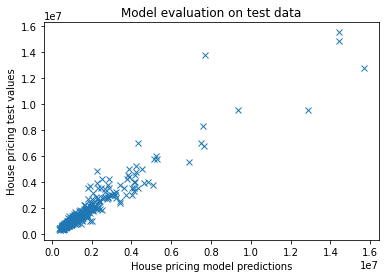

In [ ]:
fname='test_data_housing.csv' # Change to testing dataset
X_test, y_test = pre_process(fname, post_dict, mean)
#print(X_test.head)
model = xgb.XGBRegressor(learning_rate=0.15, max_depth=4, n_estimators=50, booster='dart')
model.load_model("model.json")

score = model.score(X_test,y_test)
print(score)
prediction = model.predict(X_test)
print(prediction[:5])
print(y_test[:5])

#print(X_test.head)

# plt.figure(1)
# plt.hist(prediction)
# plt.hist(y_test)

plt.figure(2)
plt.plot(prediction, y_test, linestyle='None', marker='x')
plt.xlabel('House pricing model predictions')
plt.ylabel('House pricing test values')
plt.title('Model evaluation on test data')

